# Livrable 2 : Notebook Exploration des données

Dans ce NoteBook on va faire une analyse exploratoire des données. 

L'objectif de ce notebook, est de d'analyser les variables et de sélectionner les variables qui pourront nous servir dans le jeu de données réduit. Pour rappel l'idée d'application est de mettre en place un nutriscore calculé de façon globale à partir d'un jeu de données réduit. En effet, il faut choisir les données qui seront dans notre dataset réduit. 

Pour cela nous allons étuidier les corrélations entre les données entre elles, les données et la variable cible pour pouvoir mettre en place notre application.

# Import des bibliotèques

In [1]:
import dask.dataframe as dd
import numpy as np
import pandas as pd
import re
import IPython.display
import matplotlib.pyplot as plt
import seaborn as sns

import statsmodels.api as sm
import statsmodels.formula.api as smf
import scipy.stats as st

# Import des données

Importation du dataset des nouvelles données cleanées et traitées. Les données proviennent du notebook d'exploration

On crée à nouveau notre liste de feeatures à étudier.

In [2]:
features = ['proteins_100g', 'salt_100g', 'sodium_100g',
       'ingredients_that_may_be_from_palm_oil_n', 'additives_n', 'sugars_100g',
       'fat_100g', 'saturated-fat_100g', 'nutrition-score-fr_100g',
       'nutrition-score-uk_100g', 'cholesterol_100g', 'trans-fat_100g',
       'calcium_100g', 'vitamin-c_100g', 'carbohydrates_100g', 'energy_100g','fiber_100g', 'nutri grade number fr']

On importe les trois dataset. Nous partirons sur le dataset qui a subis une imputation des données par les K plus proches voisins. Les deux autres dataset pourront éventuellement nous servir pour faire des comparaisons.

In [3]:
data_ITERATIVE = pd.read_csv("data_ITERATIVE.csv")
data_KNNI = pd.read_csv("data_KNNI.csv")
data_MEDIANE = pd.read_csv("data_MEDIANE.csv")

In [4]:
data = data_KNNI

In [5]:
pd.set_option('display.max_columns', None)
data

,product_name,countries_tags,brands,energy_100g,proteins_100g,pnns_groups_1,pnns_groups_2,salt_100g,sodium_100g,ingredients_that_may_be_from_palm_oil_n,additives_n,sugars_100g,fat_100g,saturated-fat_100g,nutrition_grade_fr,nutrition-score-fr_100g,nutrition-score-uk_100g,cholesterol_100g,trans-fat_100g,calcium_100g,vitamin-c_100g,carbohydrates_100g,fiber_100g,nutri grade number fr
0,Quiche Lorraine,en:canada,Kirkland Signature,478.0,5.36,Composite foods,Pizza pies and quiche,0.49900,0.196000,0.0,3.000000,0.714,6.79,2.86,b,2.0,2.0,0.010700,0.000000,0.028600,0.000429,7.860000,0.357,2.0
1,"Pepsi, Nouveau goût !",en:france,Pepsi,177.0,0.00,Beverages,Sweetened beverages,0.02540,0.010000,0.0,2.000000,10.400,0.00,0.00,e,13.0,2.0,0.000619,0.015453,0.029142,0.013778,10.400000,0.000,5.0
2,7Up,en:france,"7Up,Pepsico",177.0,0.00,Beverages,Sweetened beverages,0.10000,0.039370,0.0,3.000000,10.400,0.00,0.00,e,13.0,2.0,0.000645,0.016099,0.028878,0.014188,10.400000,0.000,5.0
3,"Ryan's, Juice Melange, Fuji Pom Blend",en:united-states,Ryan Orchards,192.0,0.00,unknown,unknown,0.03810,0.015000,0.0,0.000000,10.420,0.00,0.00,b,2.0,2.0,0.000000,0.000000,0.000000,0.000000,11.670000,0.000,2.0
4,"Ryan's, Lemonade",en:united-states,Ryan Orchards,226.0,0.00,unknown,unknown,0.01016,0.004000,0.0,0.000000,13.330,0.00,0.00,b,2.0,2.0,0.000000,0.000000,0.000000,0.000500,13.330000,0.000,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
56627,Princes Tuna Chunks In Brine 160G,en:france,Princes,414.0,23.50,unknown,unknown,1.05000,0.413386,0.0,0.000000,0.000,0.10,0.10,b,0.0,0.0,0.046662,0.000000,0.032539,0.000184,0.100000,0.100,2.0
56628,Santa Cruz Chilli & Lime Dressing,en:united-kingdom,Newman's Own,660.0,0.30,Fat and sauces,Dressings and sauces,0.54102,0.213000,0.0,1.000000,16.700,6.90,0.50,c,6.0,6.0,0.055353,0.000000,0.111925,0.000000,23.100000,0.600,3.0
56629,Fiche Brevet,en:france,Hatier,4.0,10.00,unknown,unknown,10.00000,3.937008,0.0,2.494306,1.000,0.00,1.00,b,0.0,0.0,0.000000,0.000000,0.027995,0.020881,4.131414,10.000,2.0
56630,Thé vert Earl grey,en:france,Lobodis,21.0,0.50,Beverages,Non-sugared beverages,0.02540,0.010000,0.0,0.000000,0.500,0.20,0.20,c,2.0,0.0,0.000000,0.000000,0.000000,0.002460,0.500000,0.200,3.0


On créer une liste vide, qui nous permettra d'ajouter au fur et à mesure les colonnes que nous allons supprimer.

In [6]:
drop_colonnes =[]

In [7]:
col_data = data.columns
print(f'Colonne \n{col_data}')

Colonne 
Index(['product_name', 'countries_tags', 'brands', 'energy_100g',
       'proteins_100g', 'pnns_groups_1', 'pnns_groups_2', 'salt_100g',
       'sodium_100g', 'ingredients_that_may_be_from_palm_oil_n', 'additives_n',
       'sugars_100g', 'fat_100g', 'saturated-fat_100g', 'nutrition_grade_fr',
       'nutrition-score-fr_100g', 'nutrition-score-uk_100g',
       'cholesterol_100g', 'trans-fat_100g', 'calcium_100g', 'vitamin-c_100g',
       'carbohydrates_100g', 'fiber_100g', 'nutri grade number fr'],
      dtype='object')


In [8]:
data = data.set_index('product_name')

# Milestone 4 : Analyse exploratoire – Analyse uni-variée et bi-variée

La prmière analyse exploratoire univariée et bi-variée  va avoir pour objectif de valider que le jeu de données est prêt et pertinent pour valider notre application.

Dans un premier temps nous allons décrire les données de façon statistiques à l'aide la fonction describe.


In [9]:
data.describe()

,energy_100g,proteins_100g,salt_100g,sodium_100g,ingredients_that_may_be_from_palm_oil_n,additives_n,sugars_100g,fat_100g,saturated-fat_100g,nutrition-score-fr_100g,nutrition-score-uk_100g,cholesterol_100g,trans-fat_100g,calcium_100g,vitamin-c_100g,carbohydrates_100g,fiber_100g,nutri grade number fr
count,56632.000000,56632.000000,56632.000000,56632.000000,56632.000000,56632.000000,56632.000000,56632.000000,56632.000000,56632.000000,56632.000000,56632.000000,56632.000000,56632.000000,56632.000000,56632.000000,56632.000000,56632.000000
mean,372.486162,4.281038,1.562554,0.615178,0.048094,1.934083,7.116608,3.146441,1.214938,4.432953,3.995444,0.013879,0.016552,0.056275,0.008578,11.397308,0.761140,2.725155
std,221.438163,6.278358,6.341373,2.496595,0.222585,2.256452,8.355219,4.224474,2.394057,4.568181,4.286735,0.027947,0.354702,0.504931,0.075342,10.501408,1.754817,0.814559
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,192.000000,0.158000,0.086360,0.034000,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,4.230000,0.000000,2.000000
50%,363.000000,1.670000,0.627380,0.247000,0.000000,1.000000,4.000000,1.560000,0.300000,3.000000,2.000000,0.000000,0.000000,0.019640,0.001837,9.170000,0.200000,3.000000
75%,550.000000,4.760000,1.300000,0.511811,0.000000,3.000000,11.000000,4.800000,1.760000,6.000000,5.000000,0.015331,0.000000,0.071000,0.008000,15.570000,1.100000,3.000000
max,799.000000,93.330000,99.930000,39.342520,3.000000,24.000000,99.000000,92.000000,99.000000,30.000000,30.000000,0.996000,30.000000,69.500000,12.000000,99.300000,99.000000,5.000000


On peut observer que les données sont très hétérogènes entre elle. C'est à dire qu'il y a une grande dispersion. De plus on remarque que les données entre elles, on des écarts-type très différents. On note par exemple que les "carbohydrates_100g" on une std de 10.5 et que les cholesterol_100g ont une std de 0.02.

In [10]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 56632 entries, Quiche Lorraine to Mint Melange Tea A Blend Of Peppermint, Lemon Grass And Spearmint
Data columns (total 23 columns):
 #   Column                                   Non-Null Count  Dtype  
---  ------                                   --------------  -----  
 0   countries_tags                           56617 non-null  object 
 1   brands                                   56632 non-null  object 
 2   energy_100g                              56632 non-null  float64
 3   proteins_100g                            56632 non-null  float64
 4   pnns_groups_1                            56632 non-null  object 
 5   pnns_groups_2                            56632 non-null  object 
 6   salt_100g                                56632 non-null  float64
 7   sodium_100g                              56632 non-null  float64
 8   ingredients_that_may_be_from_palm_oil_n  56632 non-null  float64
 9   additives_n                              56632 

In [11]:
data.columns

Index(['countries_tags', 'brands', 'energy_100g', 'proteins_100g',
       'pnns_groups_1', 'pnns_groups_2', 'salt_100g', 'sodium_100g',
       'ingredients_that_may_be_from_palm_oil_n', 'additives_n', 'sugars_100g',
       'fat_100g', 'saturated-fat_100g', 'nutrition_grade_fr',
       'nutrition-score-fr_100g', 'nutrition-score-uk_100g',
       'cholesterol_100g', 'trans-fat_100g', 'calcium_100g', 'vitamin-c_100g',
       'carbohydrates_100g', 'fiber_100g', 'nutri grade number fr'],
      dtype='object')

<AxesSubplot:title={'center':'Boxplot'}>

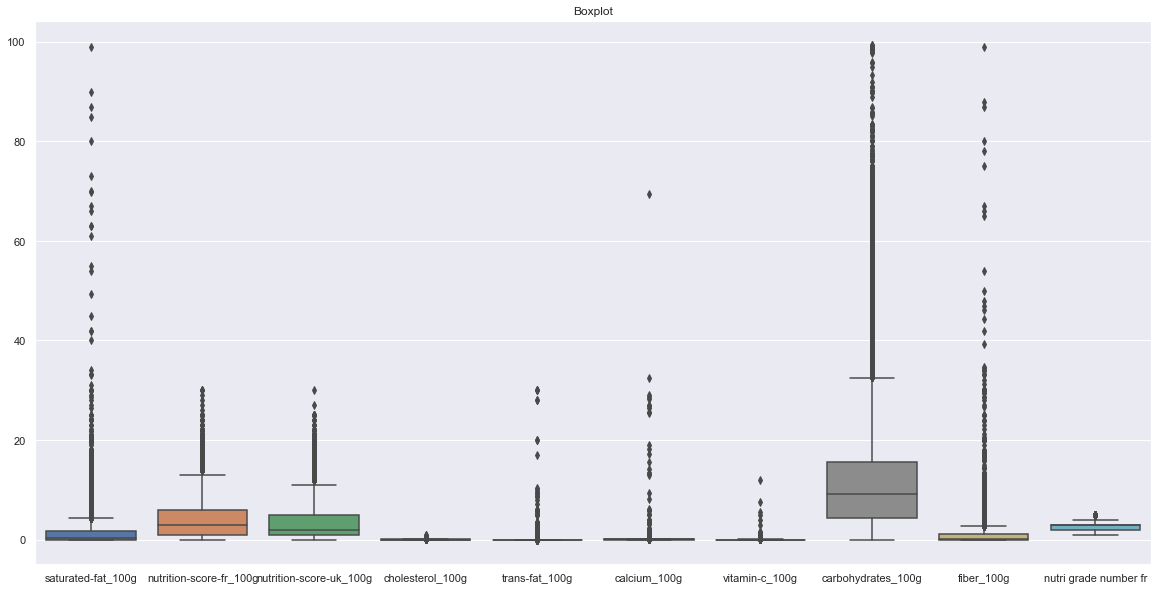

In [12]:
sns.set(rc = {'figure.figsize':(20,10)})
plt.title("Boxplot")
sns.boxplot(data =data[['saturated-fat_100g', 'nutrition_grade_fr',
       'nutrition-score-fr_100g', 'nutrition-score-uk_100g',
       'cholesterol_100g', 'trans-fat_100g', 'calcium_100g', 'vitamin-c_100g',
       'carbohydrates_100g', 'fiber_100g', 'nutri grade number fr'
                            ]])

Puis on utilise des graphiques de type boxplot pour evaluer de façon graphique la statistique de notre nouveau jeu de données. On observe des données dispersées d efaçon hétérogènes. Il y a beaucoup de valeur qui sortent des bornes de 75%.

<AxesSubplot:title={'center':'Boxplot'}>

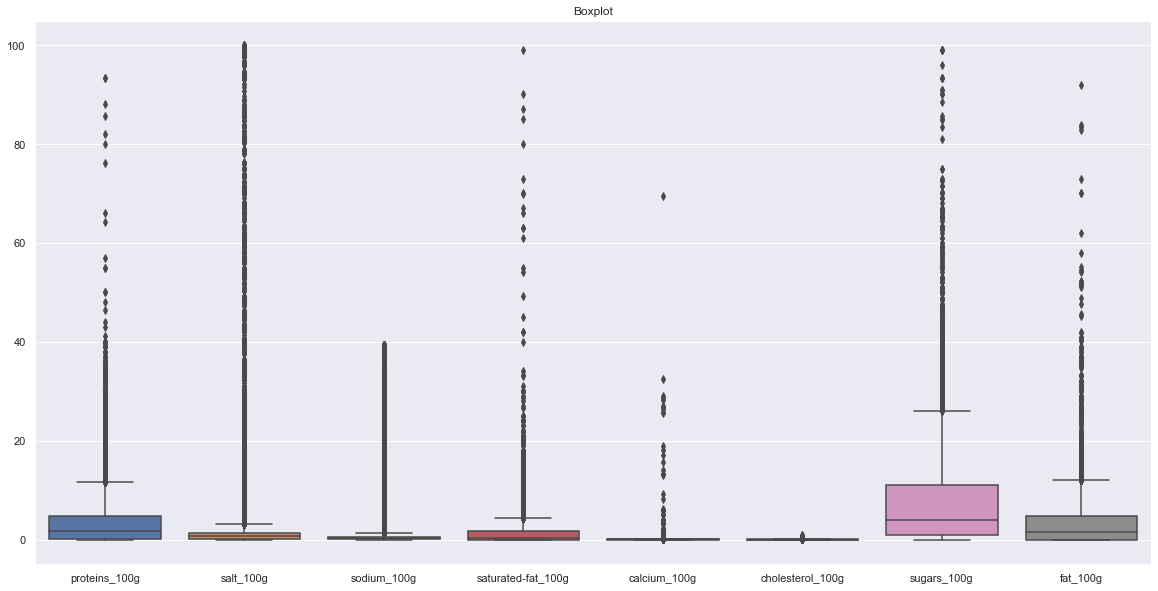

In [13]:
sns.set(rc = {'figure.figsize':(20,10)})
plt.title("Boxplot")
sns.boxplot(data =data[["proteins_100g",
                        "salt_100g",'sodium_100g', 
                        'saturated-fat_100g',
                        'calcium_100g',
                        'cholesterol_100g',
                        'sugars_100g', 
                        'fat_100g'
                            ]])

On observe graphiquement la dispersion des variables. La description est confirmé par l'application graphique.

<AxesSubplot:title={'center':'Energy'}>

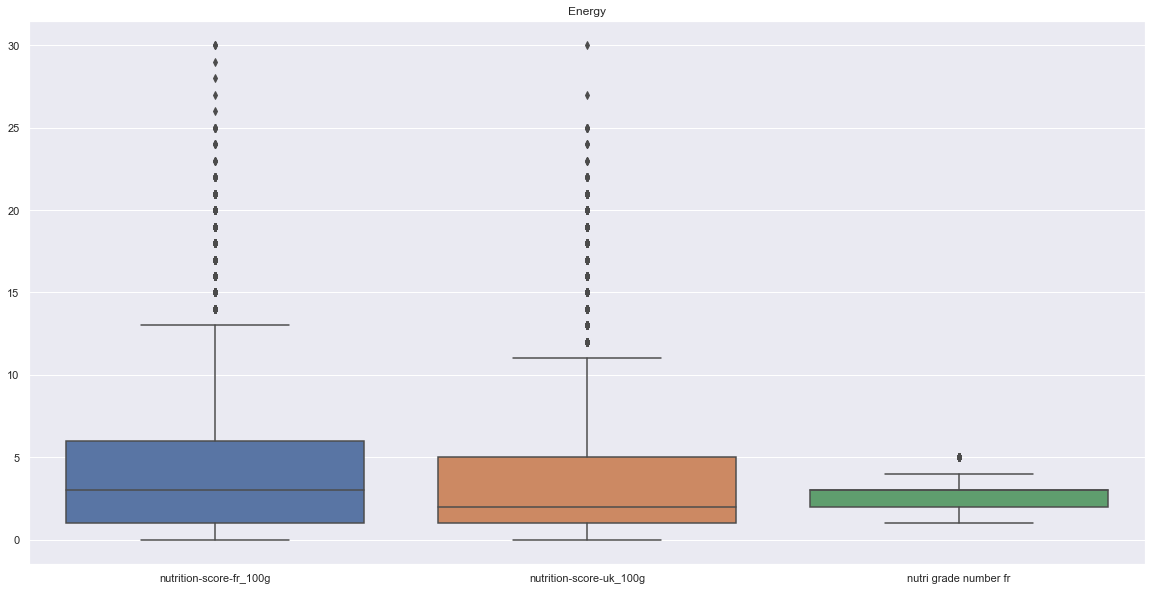

In [15]:
sns.set(rc = {'figure.figsize':(20,10)})
plt.title("Energy")
sns.boxplot(data =data [['nutrition-score-fr_100g','nutrition-score-uk_100g','nutri grade number fr']])

La distribution entre les nutriscores FR et les nutriscores UK sont similaires graphiquement, pour cela on va garder le nutriscore fr en particulier. O peut noter que le nutriscore UK est légèrement décaler par rapport au français.On compare le nutriscore grade et le nutriscore _100G

In [16]:
data = data.reset_index()

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\categorical.py:3717: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)


a       54
e     1972
d     7174
c    20857
b    26575
Name: nutrition_grade_fr, dtype: int64

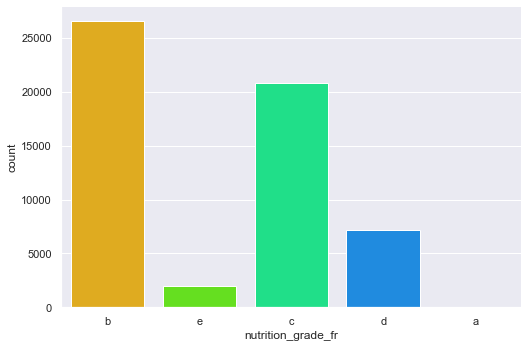

In [17]:
sns.set(rc = {'figure.figsize':(20,10)})
sns.factorplot(x = "nutrition_grade_fr", data = data , kind =  'count', aspect= 1.5, palette = 'gist_rainbow' )
data["nutrition_grade_fr"].value_counts().sort_values()

On observe une grosse proportion de nutriscore B. Et quasiment aucun nutriscore a. Il y a très peu de nutriscore e. On peut remarquer qu'une grande partie des nutriscores a rétiré avait beaucoup de données manquantes et/ou abberantes.

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\categorical.py:3717: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)


sugary-snacks                  1
cereals-and-potatoes           1
Salty snacks                  30
fruits-and-vegetables        118
Cereals and potatoes         415
Sugary snacks                532
Fruits and vegetables        650
Fat and sauces              1459
Fish Meat Eggs              2218
Composite foods             2492
Milk and dairy products     3015
Beverages                   3272
unknown                    42429
Name: pnns_groups_1, dtype: int64

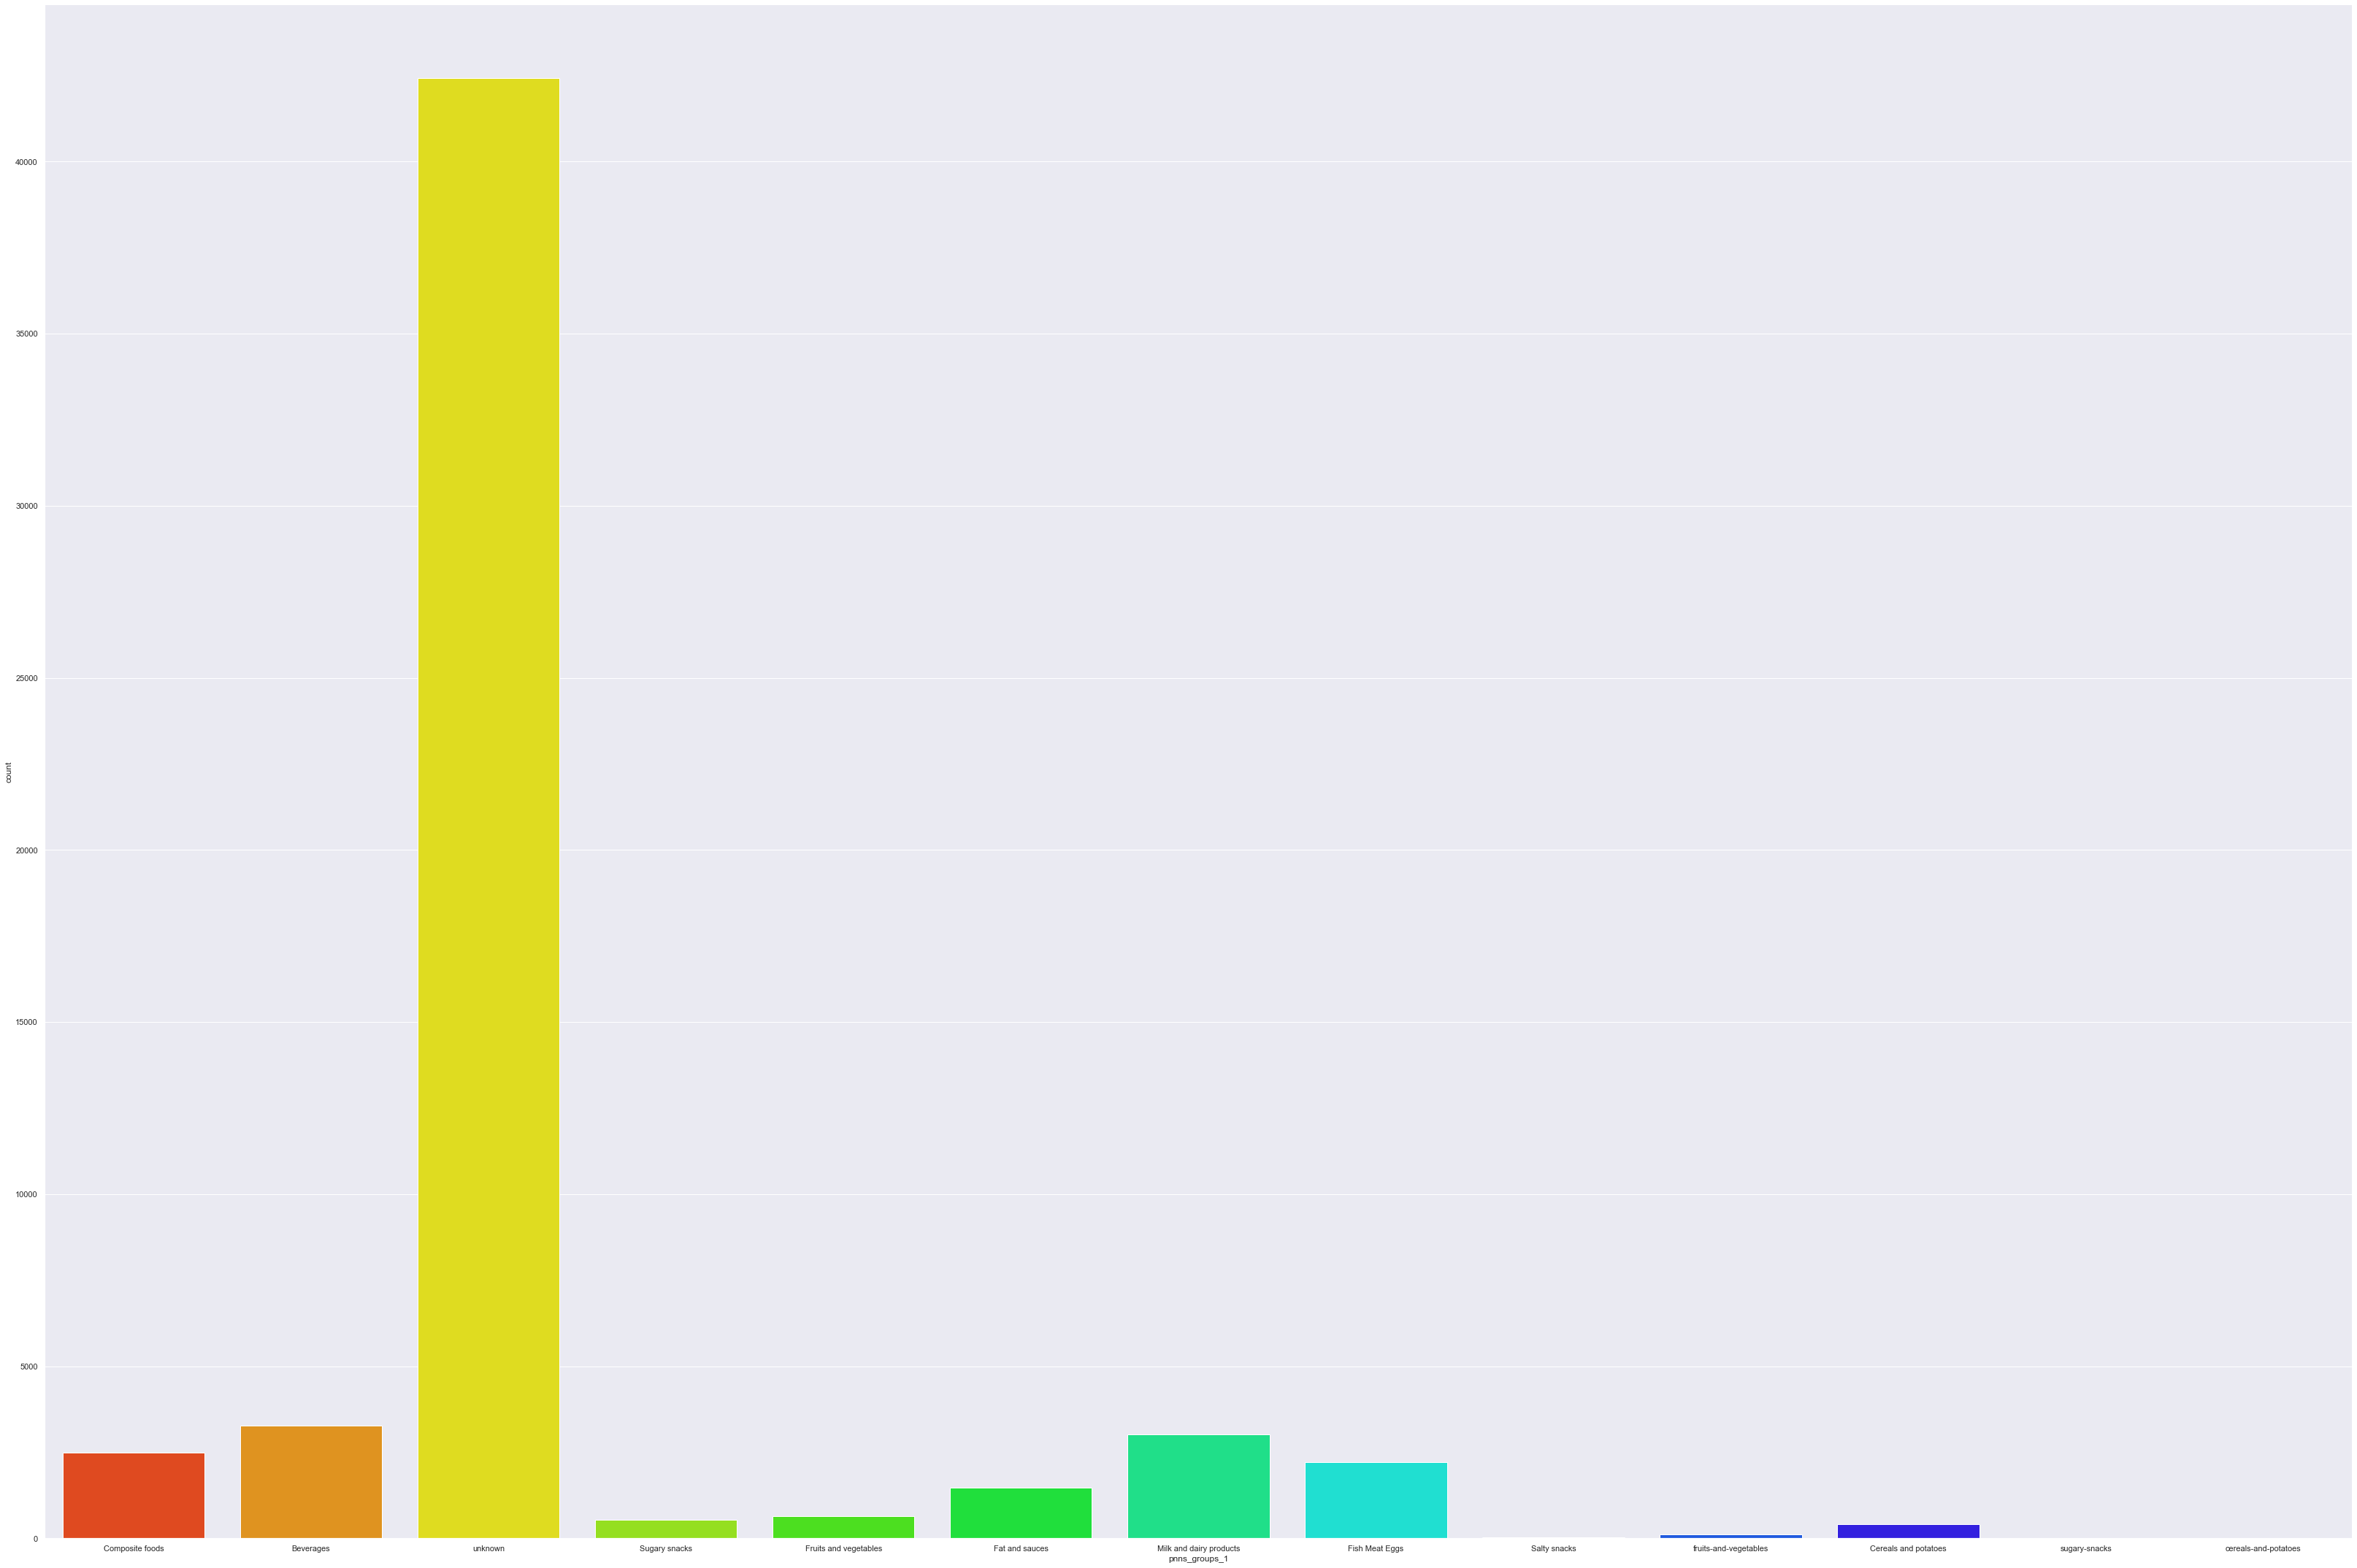

In [18]:
sns.set(rc = {'figure.figsize':(20,10)})
sns.factorplot(x = "pnns_groups_1", data = data , kind =  'count', aspect= 1.5, palette = 'gist_rainbow',height =30 )
data["pnns_groups_1"].value_counts().sort_values()

In [19]:
data_pnns_1 = pd.DataFrame(data = data["pnns_groups_1"].value_counts()).reset_index() 
data_pnns_1 = data_pnns_1.rename(columns = {"pnns_groups_1":"Count","index":"pnns_groups_1"})
data_pnns_1 = data_pnns_1.set_index("pnns_groups_1")
data_pnns_1

,Count
pnns_groups_1,
unknown,42429
Beverages,3272
Milk and dairy products,3015
Composite foods,2492
Fish Meat Eggs,2218
Fat and sauces,1459
Fruits and vegetables,650
Sugary snacks,532
Cereals and potatoes,415


([<matplotlib.patches.Wedge at 0x2518d32e520>,
 [Text(-0.7758733903578908, 0.7797566813657656, 'unknown'),
  Text(0.19316274870174407, -1.0829072686587653, 'Beverages'),
  Text(0.5516022958664912, -0.9517010597844345, 'Milk and dairy products'),
  Text(0.8123002060001278, -0.7417333586486118, 'Composite foods'),
  Text(0.9763342356590842, -0.5067262182678061, 'Fish Meat Eggs'),
  Text(1.058738870190652, -0.29844933363541304, 'Fat and sauces'),
  Text(1.0863385621370805, -0.1728251382581268, 'Fruits and vegetables'),
  Text(1.095328113250623, -0.10127351244442394, 'Sugary snacks'),
  Text(1.099134848619984, -0.043618626171914573, 'Cereals and potatoes'),
  Text(1.0999439376775029, -0.011105582673142838, 'fruits-and-vegetables'),
  Text(1.099998043586343, -0.002074633996074165, 'Salty snacks'),
  Text(1.0999999847813076, -0.00018297847808714063, 'sugary-snacks'),
  Text(1.0999999983121782, -6.093610163083789e-05, 'cereals-and-potatoes')],
 [Text(-0.4232036674679404, 0.4253218261995085, '

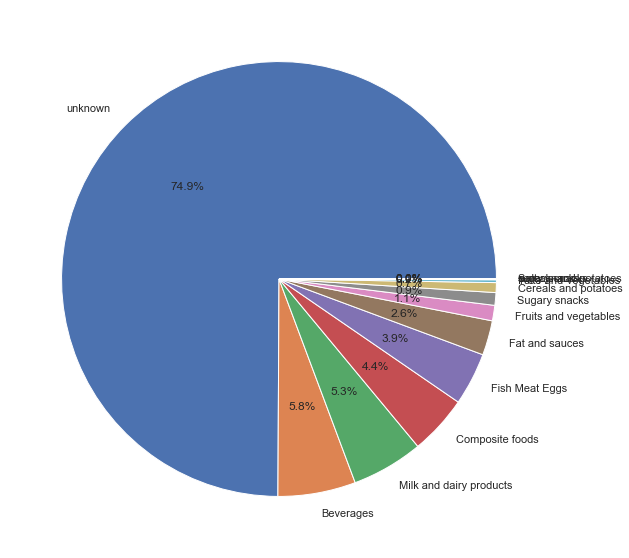

In [20]:
plt.pie(x = "Count", data= data_pnns_1,autopct="%.1f%%", labels = data_pnns_1.index )

Dans le graphique, 75% de la données est inconnue.

In [25]:
data_country = pd.DataFrame(data = data['countries_tags'].value_counts()).reset_index() 
data_country  = data_country.rename(columns = {"countries_tags":"Count","index":"countries_tags"})
data_country = data_country.set_index("countries_tags")
data_country  = data_country [data_country.Count>50]
data_country 

,Count
countries_tags,
en:united-states,33100
en:france,16879
en:switzerland,2647
en:germany,1161
en:spain,646
en:united-kingdom,352
"en:france,en:switzerland",284
en:australia,170
en:belgium,143


([<matplotlib.patches.Wedge at 0x23ebeb2e3d0>,
 [Text(-0.31876277168423955, 1.0528011661221608, 'en:united-states'),
  Text(-0.03503911003351704, -1.0994417950796938, 'en:france'),
  Text(0.96396970153594, -0.5298701864803407, 'en:switzerland'),
  Text(1.05467727529043, -0.31249935197685547, 'en:germany'),
  Text(1.0809752459325404, -0.203697122417289, 'en:spain'),
  Text(1.0907140057671998, -0.1426287405233219, 'en:united-kingdom'),
  Text(1.0951233717019893, -0.10346400703658748, 'en:france,en:switzerland'),
  Text(1.097411240461723, -0.07542260475655053, 'en:australia'),
  Text(1.0985705475096237, -0.05606025458741497, 'en:belgium'),
  Text(1.0992234561933933, -0.041325456491749124, 'en:belgium,en:france'),
  Text(1.0995927781818702, -0.02992861791457878, 'en:portugal'),
  Text(1.099817881794176, -0.020015666008706037, 'en:france,en:united-kingdom'),
  Text(1.099941541038867, -0.01134047164108659, 'en:italy'),
  Text(1.099994328948851, -0.0035321778504341216, 'en:france,en:united-st

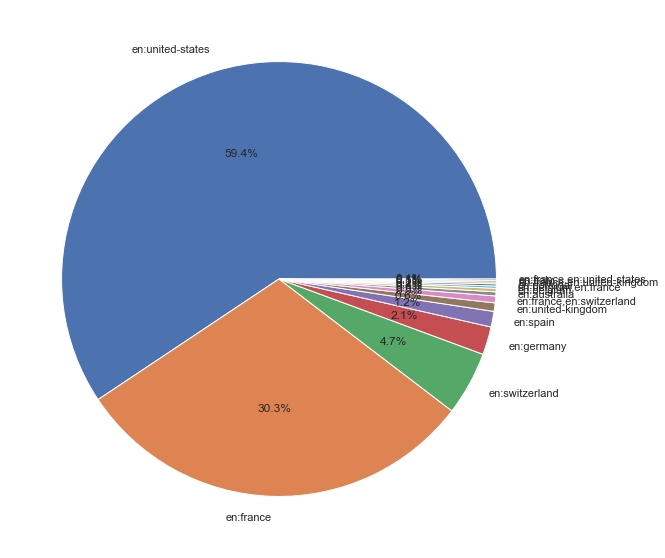

In [26]:
plt.pie(x = "Count", data= data_country ,autopct="%.1f%%", labels = data_country .index )

Les produits viennent en particuler de deux pays, la france et les etats unis.

In [27]:
data_1 = data.reset_index()

On utilise une matrice correlation pour voir à quel point les variables sont correlées entre elle ou non. De part cette matrice on selectionnera les variables qui sont plus correlés car cela sera plus perninent pour nous pour faire une bonne réductioN de dimension.

,proteins_100g,salt_100g,sodium_100g,ingredients_that_may_be_from_palm_oil_n,additives_n,sugars_100g,fat_100g,saturated-fat_100g,nutrition-score-fr_100g,nutrition-score-uk_100g,cholesterol_100g,trans-fat_100g,calcium_100g,vitamin-c_100g,carbohydrates_100g,energy_100g,fiber_100g,nutri grade number fr
proteins_100g,NaN,NaN,NaN,NaN,NaN,NaN,30.504917,21.537953,NaN,15.226719,70.808399,NaN,NaN,NaN,NaN,44.766035,NaN,NaN
salt_100g,NaN,NaN,99.999999,NaN,NaN,NaN,NaN,NaN,23.310055,27.169515,NaN,NaN,NaN,NaN,NaN,NaN,NaN,14.248070
sodium_100g,NaN,99.999999,NaN,NaN,NaN,NaN,NaN,NaN,23.310137,27.169606,NaN,NaN,NaN,NaN,NaN,NaN,NaN,14.248099
ingredients_that_may_be_from_palm_oil_n,NaN,NaN,NaN,NaN,29.613822,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
additives_n,NaN,NaN,NaN,29.613822,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,16.860600,17.291317,NaN,11.242379
sugars_100g,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,31.132291,30.552297,NaN,NaN,NaN,NaN,70.374678,21.982734,NaN,24.683042
fat_100g,30.504917,NaN,NaN,NaN,NaN,NaN,NaN,67.126563,25.728585,34.758664,33.557284,NaN,NaN,NaN,NaN,62.565260,NaN,21.536263
saturated-fat_100g,21.537953,NaN,NaN,NaN,NaN,NaN,67.126563,NaN,24.897184,31.608841,23.935163,NaN,NaN,NaN,NaN,39.596571,11.987233,20.645668
nutrition-score-fr_100g,NaN,23.310055,23.310137,NaN,NaN,31.132291,25.728585,24.897184,NaN,87.738521,10.506886,NaN,NaN,NaN,20.045925,33.216051,NaN,90.701678
nutrition-score-uk_100g,15.226719,27.169515,27.169606,NaN,NaN,30.552297,34.758664,31.608841,87.738521,NaN,16.502075,NaN,NaN,NaN,22.955628,44.644477,NaN,71.023154


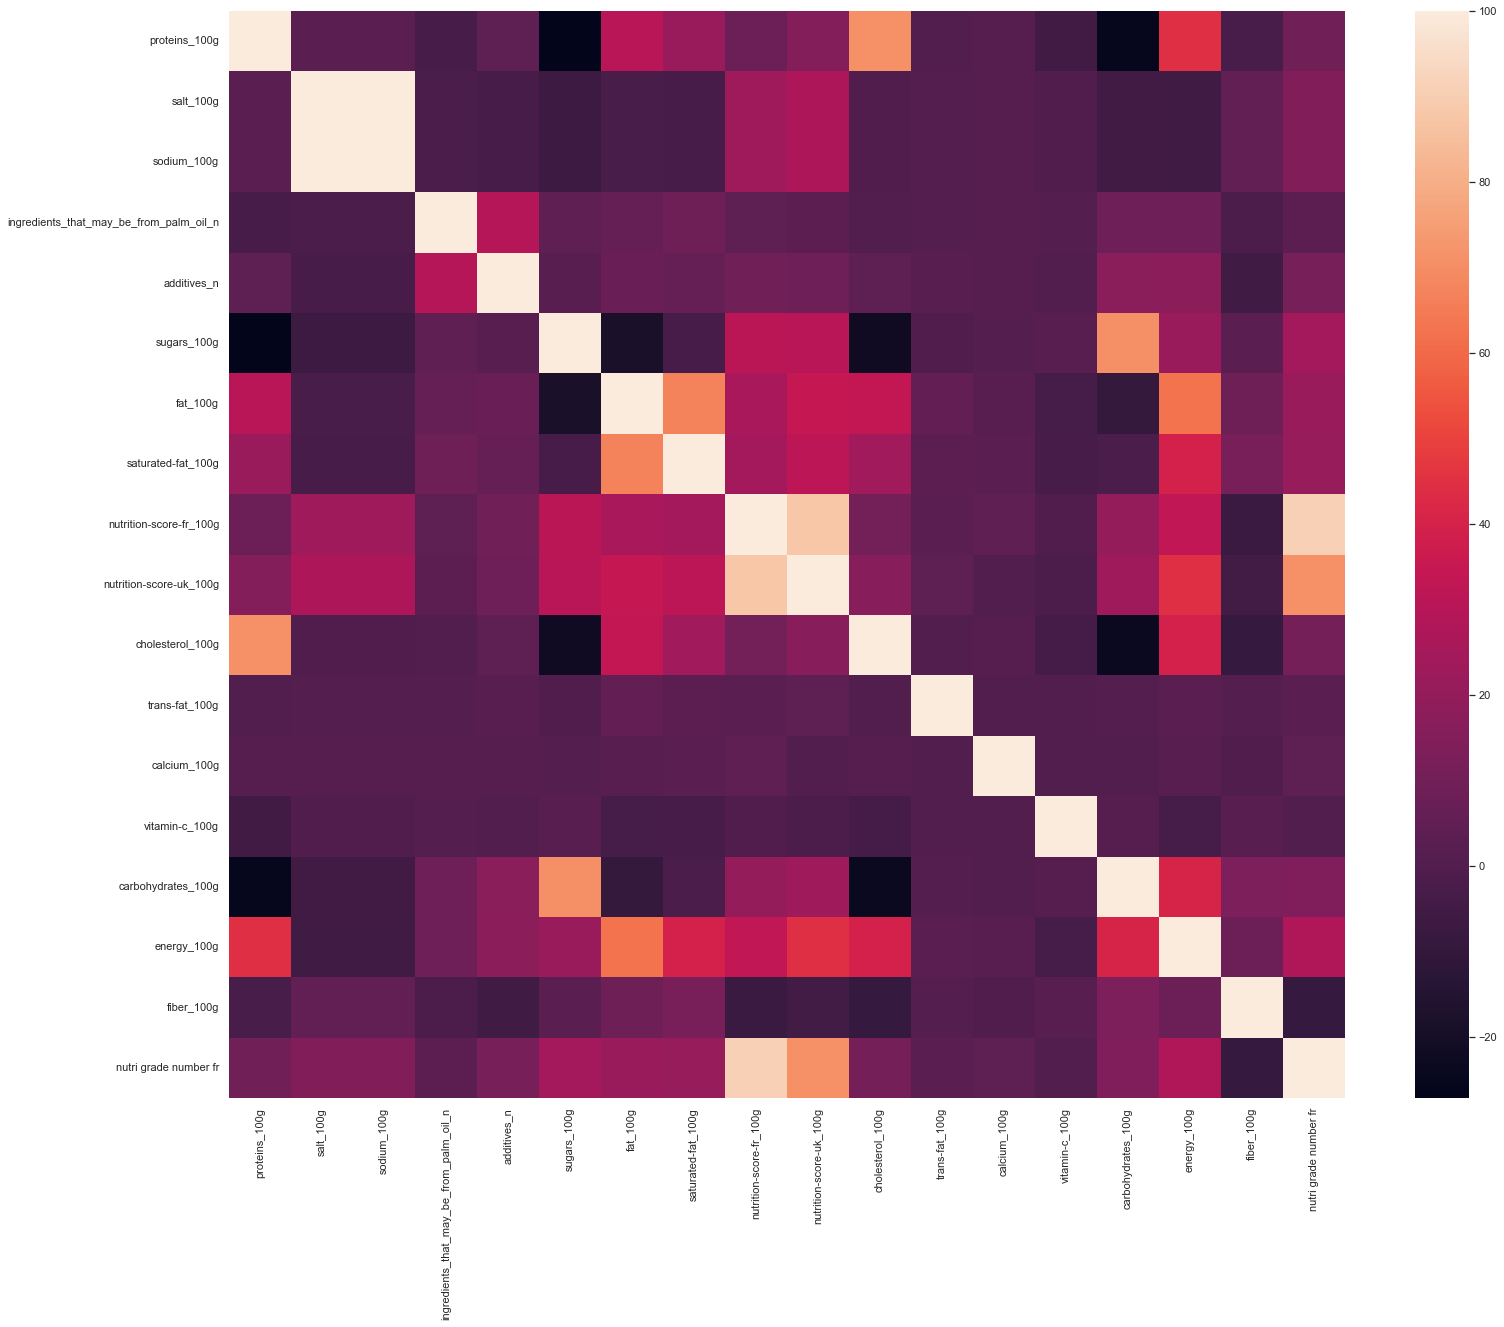

In [28]:
plt.figure(figsize= (25,20))
corr = data_1[features].corr(method = 'pearson')*100
sns.heatmap(corr)
corre = corr[(corr[:]>10) & (corr[:] < 100) ]
corre

In [29]:
corre = corr[(corr[:]>50) & (corr[:] < 100) ]
corre

,proteins_100g,salt_100g,sodium_100g,ingredients_that_may_be_from_palm_oil_n,additives_n,sugars_100g,fat_100g,saturated-fat_100g,nutrition-score-fr_100g,nutrition-score-uk_100g,cholesterol_100g,trans-fat_100g,calcium_100g,vitamin-c_100g,carbohydrates_100g,energy_100g,fiber_100g,nutri grade number fr
proteins_100g,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,70.808399,NaN,NaN,NaN,NaN,NaN,NaN,NaN
salt_100g,NaN,NaN,99.999999,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
sodium_100g,NaN,99.999999,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
ingredients_that_may_be_from_palm_oil_n,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
additives_n,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
sugars_100g,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,70.374678,NaN,NaN,NaN
fat_100g,NaN,NaN,NaN,NaN,NaN,NaN,NaN,67.126563,NaN,NaN,NaN,NaN,NaN,NaN,NaN,62.56526,NaN,NaN
saturated-fat_100g,NaN,NaN,NaN,NaN,NaN,NaN,67.126563,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
nutrition-score-fr_100g,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,87.738521,NaN,NaN,NaN,NaN,NaN,NaN,NaN,90.701678
nutrition-score-uk_100g,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,87.738521,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,71.023154


Les variables Salt et Sodium corréles sont très corrélés en elles.Ainsi que lees variables nutriscores.
On va enlever les variables sodium et nutriscores UK et Grade number FR car il y a de la redondance de données. Le nutriscore 100G est plus précis que le Nutri grade number donc elle sera plus pertinente.

Il y a beaucoup de de variables peu corrélées entre elles. On va essayer de garder celle qui sont le plus corrélées avec le  nutriscore.

In [30]:
corr[['nutrition-score-fr_100g']].sort_values(by = "nutrition-score-fr_100g" , ascending = False )

,nutrition-score-fr_100g
nutrition-score-fr_100g,100.000000
nutri grade number fr,90.701678
nutrition-score-uk_100g,87.738521
energy_100g,33.216051
sugars_100g,31.132291
fat_100g,25.728585
saturated-fat_100g,24.897184
sodium_100g,23.310137
salt_100g,23.310055
carbohydrates_100g,20.045925


In [31]:
colonnes = ["nutrition-score-fr_100g",'sodium_100g','nutrition-score-uk_100g']

for col in colonnes : 
    drop_colonnes.append(col)
##data_1 = data_1.drop(columns = drop_colonnes)

In [32]:
correle = corr[(corr['nutrition-score-fr_100g']>10) & (corr['nutrition-score-fr_100g']<85)]['nutrition-score-fr_100g']

In [33]:
correle

salt_100g             23.310055
sodium_100g           23.310137
sugars_100g           31.132291
fat_100g              25.728585
saturated-fat_100g    24.897184
cholesterol_100g      10.506886
carbohydrates_100g    20.045925
energy_100g           33.216051
Name: nutrition-score-fr_100g, dtype: float64

On obtient la liste des features les plus correlées avec le nutriscore. On observe que les gras saturés, le fat, les energy et le sugar sont les plus corrélés avec le nutriscore. 

On garde les valeurs suivantes qui sont le plus correlés avec les autres valeurs et qui nous semblent les plus pertinentes :
- salt_100g 
- sugars_100g 
- fat_100g
- saturated-fat_100g
- energy_100g 
- cholesterol_100g
- carbohydrates_100g 

In [34]:
features

['proteins_100g',
 'salt_100g',
 'sodium_100g',
 'ingredients_that_may_be_from_palm_oil_n',
 'additives_n',
 'sugars_100g',
 'fat_100g',
 'saturated-fat_100g',
 'nutrition-score-fr_100g',
 'nutrition-score-uk_100g',
 'cholesterol_100g',
 'trans-fat_100g',
 'calcium_100g',
 'vitamin-c_100g',
 'carbohydrates_100g',
 'energy_100g',
 'fiber_100g',
 'nutri grade number fr']

### OLS

In [35]:
from sklearn.model_selection import train_test_split

import statsmodels.api as sm

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

In [36]:
features

['proteins_100g',
 'salt_100g',
 'sodium_100g',
 'ingredients_that_may_be_from_palm_oil_n',
 'additives_n',
 'sugars_100g',
 'fat_100g',
 'saturated-fat_100g',
 'nutrition-score-fr_100g',
 'nutrition-score-uk_100g',
 'cholesterol_100g',
 'trans-fat_100g',
 'calcium_100g',
 'vitamin-c_100g',
 'carbohydrates_100g',
 'energy_100g',
 'fiber_100g',
 'nutri grade number fr']

On applique maintenant une OLS pour voir la  significativité des variables sur le nutriscore. Pour observer à quel point les features vont impacter ce même nutriscore.

In [38]:
##Features
X = data_1[['proteins_100g',
             'salt_100g',
             'ingredients_that_may_be_from_palm_oil_n',
             'additives_n',
             'sugars_100g',
             'fat_100g',
             'saturated-fat_100g',
             'cholesterol_100g',
             'trans-fat_100g',
             'calcium_100g',
             'vitamin-c_100g',
             'carbohydrates_100g',
             'energy_100g',
             'fiber_100g'
           ]]

##Label
Y = data_1[['nutrition-score-fr_100g']]

##Split data en train et test set
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size = 0.2 , random_state = 100, shuffle=False)

model = sm.OLS(y_train,x_train)
results = model.fit()
print('Impacts des variables',results.summary())

Impacts des variables                                    OLS Regression Results                                   
Dep. Variable:     nutrition-score-fr_100g   R-squared (uncentered):                   0.648
Model:                                 OLS   Adj. R-squared (uncentered):              0.648
Method:                      Least Squares   F-statistic:                              5956.
Date:                     Tue, 29 Nov 2022   Prob (F-statistic):                        0.00
Time:                             10:15:12   Log-Likelihood:                     -1.2312e+05
No. Observations:                    45305   AIC:                                  2.463e+05
Df Residuals:                        45291   BIC:                                  2.464e+05
Df Model:                               14                                                  
Covariance Type:                 nonrobust                                                  
                                              co

On obtient des P_Value inférieur à 0.05 dans la plupart  des cas (sauf les protéines), ce qui signifie que la null hypothesis est rejeté. Nos résultats ne sont donc pas du au hasard.

Les ingredients qui ont le plus d'impact sur les nutriscores sont :
- Sel
- Sucre
- Cholesterol
- Gras saturés
- Gras transformés
- Gras

On confirme donc la présence de ces features dans notre jeu de données réduit. Nous allons tout de même garder les données très correlées avec le nutricore.

### Tracé par variable

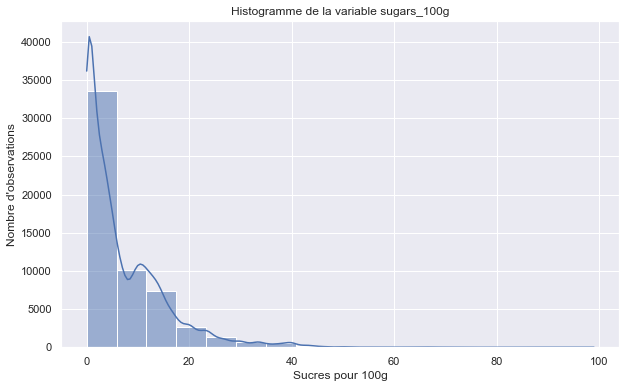

In [39]:
fig = plt.figure(figsize=(10,6))
ax = fig.add_subplot(111)
ax = sns.histplot(data=data, x='sugars_100g', bins="sturges", kde=True)
ax.set_xlabel("Sucres pour 100g")
ax.set_ylabel("Nombre d'observations")
ax.set_title("Histogramme de la variable sugars_100g")

plt.show()

On observe que les aliments ont en générales des quantités de sucre inférieurs à 20g de sucre pour 100g d'aliment. Les aliments se regroupent entre 0-15 G/100G

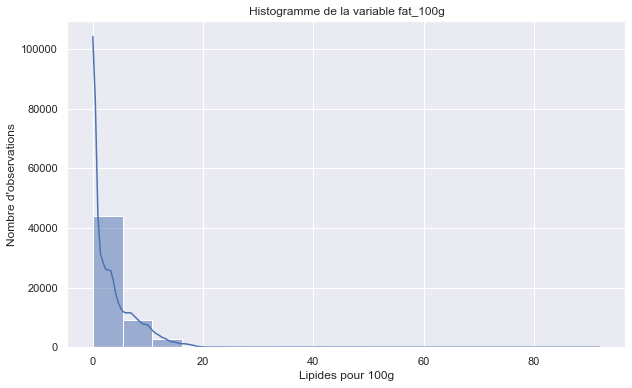

In [40]:
fig = plt.figure(figsize=(10,6))
ax = fig.add_subplot(111)
ax = sns.histplot(data=data, x='fat_100g', bins="sturges", kde=True)
ax.set_xlabel("Lipides pour 100g")
ax.set_ylabel("Nombre d'observations")
ax.set_title("Histogramme de la variable fat_100g")

plt.show()

Les lipide se regroupent autour de 15g pour 100 g.

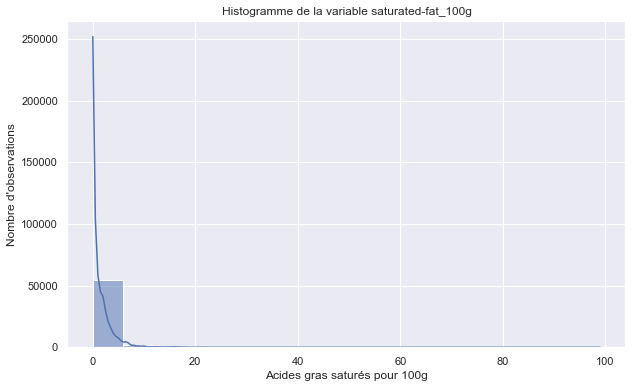

In [36]:
fig = plt.figure(figsize=(10,6))
ax = fig.add_subplot(111)
ax = sns.histplot(data=data, x='saturated-fat_100g', bins="sturges", kde=True)
ax.set_xlabel("Acides gras saturés pour 100g")
ax.set_ylabel("Nombre d'observations")
ax.set_title("Histogramme de la variable saturated-fat_100g")

plt.show()

Les gras saturés se retrouvent autour de 0-5 G dans la majortié des cas.

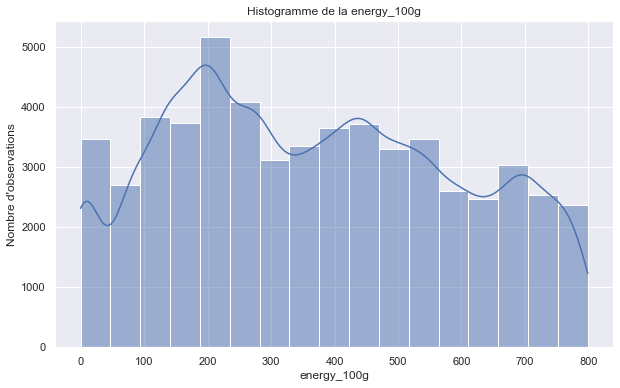

In [37]:
fig = plt.figure(figsize=(10,6))
ax = fig.add_subplot(111)
ax = sns.histplot(data=data, x='energy_100g', bins="sturges", kde=True)
ax.set_xlabel("energy_100g")
ax.set_ylabel("Nombre d'observations")
ax.set_title("Histogramme de la energy_100g")

plt.show()

Les energies/100G sont très variables et étendus.

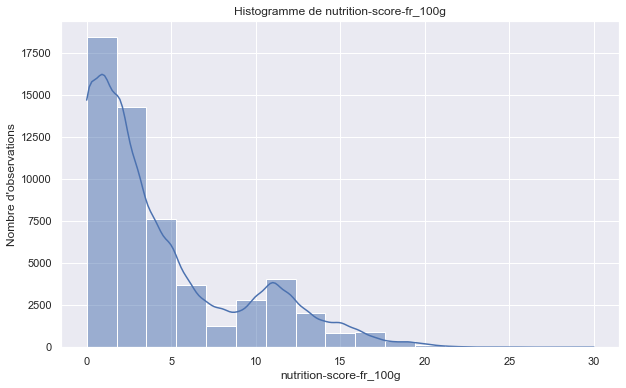

In [41]:
fig = plt.figure(figsize=(10,6))
ax = fig.add_subplot(111)
ax = sns.histplot(data=data, x='nutrition-score-fr_100g', bins="sturges", kde=True)
ax.set_xlabel("nutrition-score-fr_100g")
ax.set_ylabel("Nombre d'observations")
ax.set_title("Histogramme de nutrition-score-fr_100g")

plt.show()

# Milestone 5 : Analyse exploratoire – Analyse multi-variée


On applique une analyse exploratoire multi-variée cela va permettre une Réduction des variables/dimensions pour éviter la redondance dans un jeu de données. 

In [42]:
corr 

,proteins_100g,salt_100g,sodium_100g,ingredients_that_may_be_from_palm_oil_n,additives_n,sugars_100g,fat_100g,saturated-fat_100g,nutrition-score-fr_100g,nutrition-score-uk_100g,cholesterol_100g,trans-fat_100g,calcium_100g,vitamin-c_100g,carbohydrates_100g,energy_100g,fiber_100g,nutri grade number fr
proteins_100g,100.000000,2.705662,2.705607,-3.010750,3.898937,-27.142506,30.504917,21.537953,7.895459,15.226719,70.808399,0.167700,1.285935,-4.803584,-25.650119,44.766035,-2.638236,9.754774
salt_100g,2.705662,100.000000,99.999999,-2.138659,-2.849887,-7.210177,-2.349926,-2.907773,23.310055,27.169515,-0.323886,1.157908,1.191422,-0.443322,-5.060151,-5.584004,4.898688,14.248070
sodium_100g,2.705607,99.999999,100.000000,-2.138674,-2.849852,-7.210082,-2.349912,-2.907761,23.310137,27.169606,-0.323879,1.157929,1.191427,-0.443319,-5.060176,-5.583909,4.898420,14.248099
ingredients_that_may_be_from_palm_oil_n,-3.010750,-2.138659,-2.138674,100.000000,29.613822,4.444870,6.335840,8.510310,3.672785,3.231996,-0.213511,0.700738,1.247866,1.015613,8.848940,8.634469,-1.367129,3.569838
additives_n,3.898937,-2.849887,-2.849852,29.613822,100.000000,2.463838,7.289117,6.347228,9.754489,8.664201,3.976537,2.174553,1.196467,-0.169348,16.860600,17.291317,-5.587090,11.242379
sugars_100g,-27.142506,-7.210177,-7.210082,4.444870,2.463838,100.000000,-18.696770,-3.170712,31.132291,30.552297,-22.122860,-0.564699,0.972765,2.620664,70.374678,21.982734,2.988158,24.683042
fat_100g,30.504917,-2.349926,-2.349912,6.335840,7.289117,-18.696770,100.000000,67.126563,25.728585,34.758664,33.557284,5.448519,1.795598,-3.420455,-9.437127,62.565260,8.268938,21.536263
saturated-fat_100g,21.537953,-2.907773,-2.907761,8.510310,6.347228,-3.170712,67.126563,100.000000,24.897184,31.608841,23.935163,3.342680,2.811527,-2.975319,-2.242507,39.596571,11.987233,20.645668
nutrition-score-fr_100g,7.895459,23.310055,23.310137,3.672785,9.754489,31.132291,25.728585,24.897184,100.000000,87.738521,10.506886,3.112760,4.300588,-0.361607,20.045925,33.216051,-7.304379,90.701678
nutrition-score-uk_100g,15.226719,27.169515,27.169606,3.231996,8.664201,30.552297,34.758664,31.608841,87.738521,100.000000,16.502075,3.758372,-0.211555,-1.721946,22.955628,44.644477,-4.571058,71.023154


<AxesSubplot:>

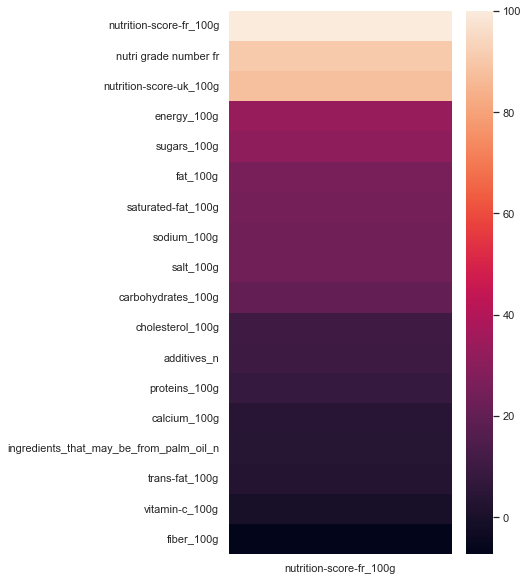

In [43]:
CORR_Nutri = corr[['nutrition-score-fr_100g']].sort_values(by = "nutrition-score-fr_100g" , ascending = False )
CORR_Nutri

plt.figure(figsize= (5,10))
sns.heatmap(CORR_Nutri)

Comme dit précédemment, on choisit les variables les plus correlées entre elles. On crée une nouvelle liste avec ces variables.

In [44]:
sel_feat = [
            "salt_100g",
            "sugars_100g",
            "fat_100g",
            "saturated-fat_100g",
            "energy_100g",
            "cholesterol_100g",
            "carbohydrates_100g",
            'nutrition-score-fr_100g'
    
           ]

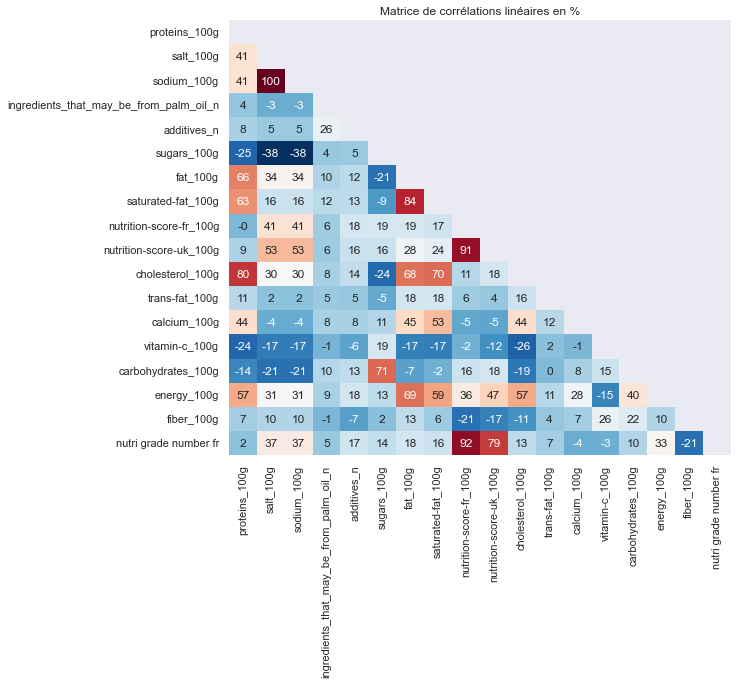

In [44]:
pearson_correlations = data_1[features].select_dtypes(include='float64').corr(method='spearman')*100.2
cleanning_mask = np.zeros_like(pearson_correlations)
upper_triangle = np.triu_indices_from(pearson_correlations)
cleanning_mask[upper_triangle] = 1

plt.figure(figsize=(9,8))

sns.heatmap(pearson_correlations, cmap="RdBu_r", mask = cleanning_mask, 
           annot = True, fmt=".0f", cbar=False)
plt.title("Matrice de corrélations linéaires en %")
plt.show()

On utilise la matrice corrélation avec une autre méthode, celle de spearman pour observer la corrélatin entre les valeurs selectionnées. cela nous permet de confirmer nos choix.

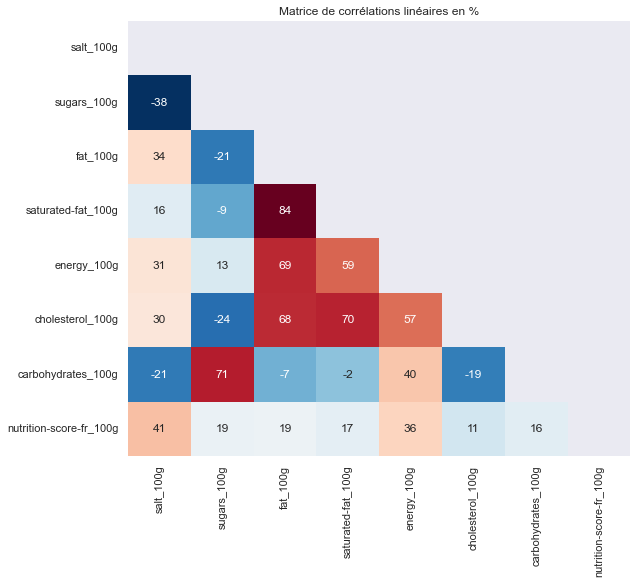

In [45]:
pearson_correlations = data_1[sel_feat].select_dtypes(include='float64').corr(method='spearman')*100.2
cleanning_mask = np.zeros_like(pearson_correlations)
upper_triangle = np.triu_indices_from(pearson_correlations)
cleanning_mask[upper_triangle] = 1

plt.figure(figsize=(9,8))

sns.heatmap(pearson_correlations, cmap="RdBu_r", mask = cleanning_mask, 
           annot = True, fmt=".0f", cbar=False)
plt.title("Matrice de corrélations linéaires en %")
plt.show()

Matrice de correlation des features gardées. On constate que les gras saturés et le gras sont corrélés à 84%. Après étude on observe que les deux features sont différentes donc il n'est pas nécessaire d'en enlever une. Ainsi qu'une confirmation de la correlation entre les energy et le cholesterol. 

## Analyse composante principale

On va faire une analyse en composantes principales (ACP ou PCA). C'est une méthode d'analyses de données multivariées permettant d'étudier des ensembles de donées multidimensionnelles avec des variables quantitatives.

L'ACP va nous permettre de :
- Faire l'étude et la visualisation des corrélations entre les variables et éventuellement limiter le nombre variables utilisés dans le dataset (opérer à une réduction de dimension)
- Obtenir des facteurs non corrélés qui sont des combinaisons linéaires des variables pour les utilser dans les méthodes de modélisation et de régression
- Observer dans des espaces à plusieurs dimensions pour identifier les groupes homogènes d'obersertion et dans le cas inverse les groupes hétérogènes.

In [46]:
from sklearn import decomposition
from sklearn import preprocessing 
from sklearn.decomposition import PCA
from sklearn.preprocessing import scale

In [47]:
##Composantes gardées
data_slf = data[sel_feat]

In [48]:
## Appel de la classe PCA
pca = PCA()
pca.fit(data_slf)

PCA()

In [49]:
## Projection des PCA et choix du nombre de composant
filtered_cols = sel_feat

## Récupération des valeurs du dataframe dans une liste
X = data.loc[:, filtered_cols].values

##Sélection des colonnes
features = data.loc[:, filtered_cols].columns

## Choix du nombre de composantes
n_comp = 7

##Normaliser les caractéristiques en supprimant la moyenne et en mettant à l'échelle la variance unitaire.
std_scale = preprocessing.StandardScaler().fit(X)
X_scaled = std_scale.transform(X)

##Decomposition en PCA
pca = decomposition.PCA(n_components=n_comp)
pca.fit(X_scaled)


pcs = pca.components_

X_projected = pca.transform(X_scaled)

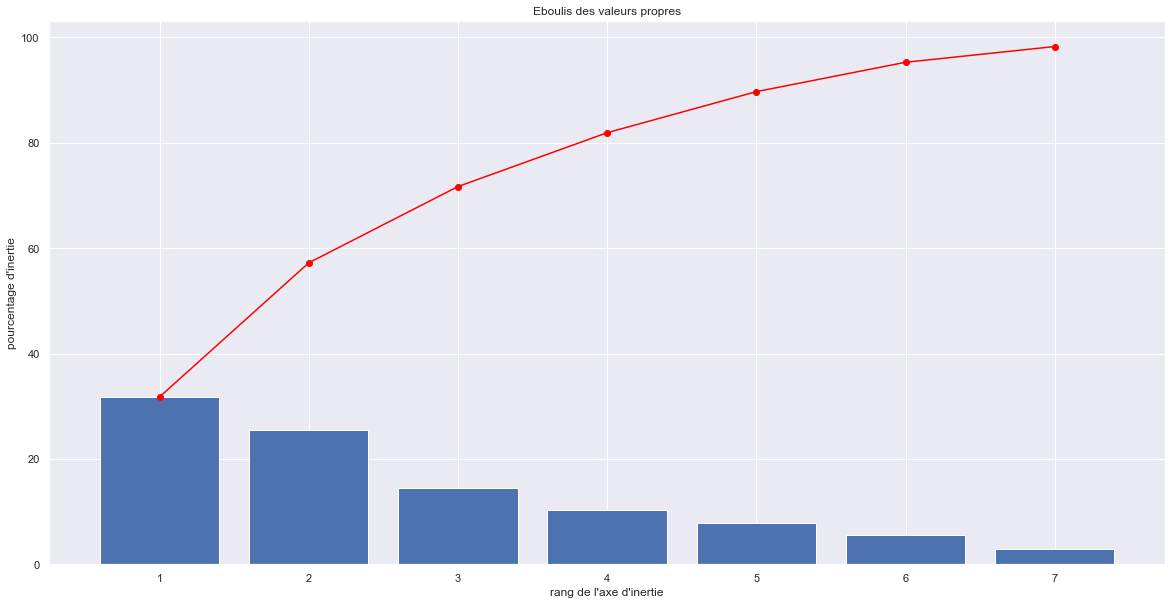

           0
0  31.757884
1  25.452249
2  14.479102
3  10.223254
4   7.796755
5   5.572076
6   2.988476


In [50]:
def display_scree_plot(pca):
    """
    Fonction qui affiche le graphique ébouli 
    """
    scree = pca.explained_variance_ratio_*100
    plt.bar(np.arange(len(scree))+1, scree)
    plt.plot(np.arange(len(scree))+1, scree.cumsum(),c="red",marker='o')
    plt.xlabel("rang de l'axe d'inertie")
    plt.ylabel("pourcentage d'inertie")
    plt.title("Eboulis des valeurs propres")
    plt.show(block=False)
    print(pd.DataFrame(scree))
    
display_scree_plot(pca)

Le diagramme d'éboulis représente la variance de chaque composant dans l'ensemble de données qui est utilisé pour déterminer le nombre de composants à conserver afin d'expliquer un pourcentage élevé de la variation des données.

Il apparaît qu'il est nécessaire d'avoir recours à 4 composantes principales, pour obtenir au 86% de l'inertie.

Analyse des composantes pour chaque variables dépendantes. Ce tableau nous montre l'expliquativité en % selon la composante F sur les variables du dataset. 

In [51]:
pcs = pd.DataFrame(pcs)
pcs

x_list = range(1, n_comp +1)
list(x_list)

pcs.columns = features
pcs.index = [f"F{i}" for i in x_list]
pcs.round(2)

,salt_100g,sugars_100g,fat_100g,saturated-fat_100g,energy_100g,cholesterol_100g,carbohydrates_100g,nutrition-score-fr_100g
F1,0.01,0.09,0.52,0.46,0.53,0.31,0.14,0.33
F2,-0.02,0.62,-0.23,-0.15,0.13,-0.31,0.61,0.22
F3,0.85,-0.04,-0.07,-0.05,-0.14,-0.03,-0.12,0.49
F4,0.04,0.04,-0.27,-0.52,0.26,0.76,0.07,-0.02
F5,0.50,-0.16,0.16,-0.03,0.31,-0.14,0.34,-0.69
F6,0.16,0.39,-0.30,0.61,-0.35,0.39,0.01,-0.29
F7,-0.09,-0.65,-0.40,0.27,-0.04,0.06,0.53,0.21


Pour la variable salt, la compote F3 explique 85% de la variance de la feature. Pour la feature fat, la composante F1 explique 52% de la feature.

In [52]:
pcs.T

,F1,F2,F3,F4,F5,F6,F7
salt_100g,0.005303,-0.020609,0.846936,0.041376,0.495065,0.162603,-0.094022
sugars_100g,0.088219,0.623593,-0.044644,0.043193,-0.155241,0.393801,-0.647847
fat_100g,0.520711,-0.228535,-0.068134,-0.270461,0.160479,-0.300214,-0.404822
saturated-fat_100g,0.461493,-0.147445,-0.054921,-0.520403,-0.026864,0.608241,0.274280
energy_100g,0.530512,0.132263,-0.142163,0.263057,0.312283,-0.347956,-0.035661
cholesterol_100g,0.310695,-0.307840,-0.030564,0.760574,-0.137609,0.388217,0.058754
carbohydrates_100g,0.137188,0.613128,-0.124176,0.065054,0.338650,0.014920,0.533263
nutrition-score-fr_100g,0.333585,0.220350,0.486296,-0.023446,-0.687891,-0.293917,0.207968


Même tableau mais cette fois-ci il est transposé.

<AxesSubplot:>

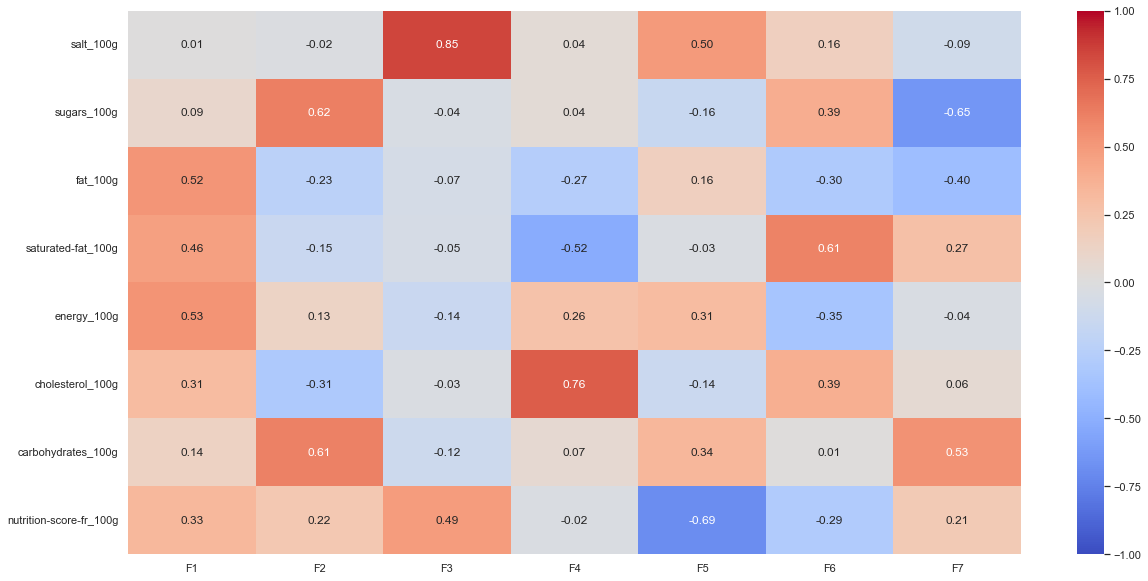

In [53]:
fig, ax = plt.subplots(figsize=(20, 10))
sns.heatmap(pcs.T, vmin=-1, vmax=1, annot=True, cmap="coolwarm", fmt="0.2f")

On regarde graphiquement les tableaux obtenus précédemment.

## Cercle de corrélation

Affichage du cercle de corrélation.  Le cercle de corrélation (ou graphique des variables) montre les corrélations entre les composantes et les variables initiales. De plus il nous l'explicativité des variables en fonction des dimensions.

Le cercle de correlation nous montre la correlation d'une variable avec son axe de projection.

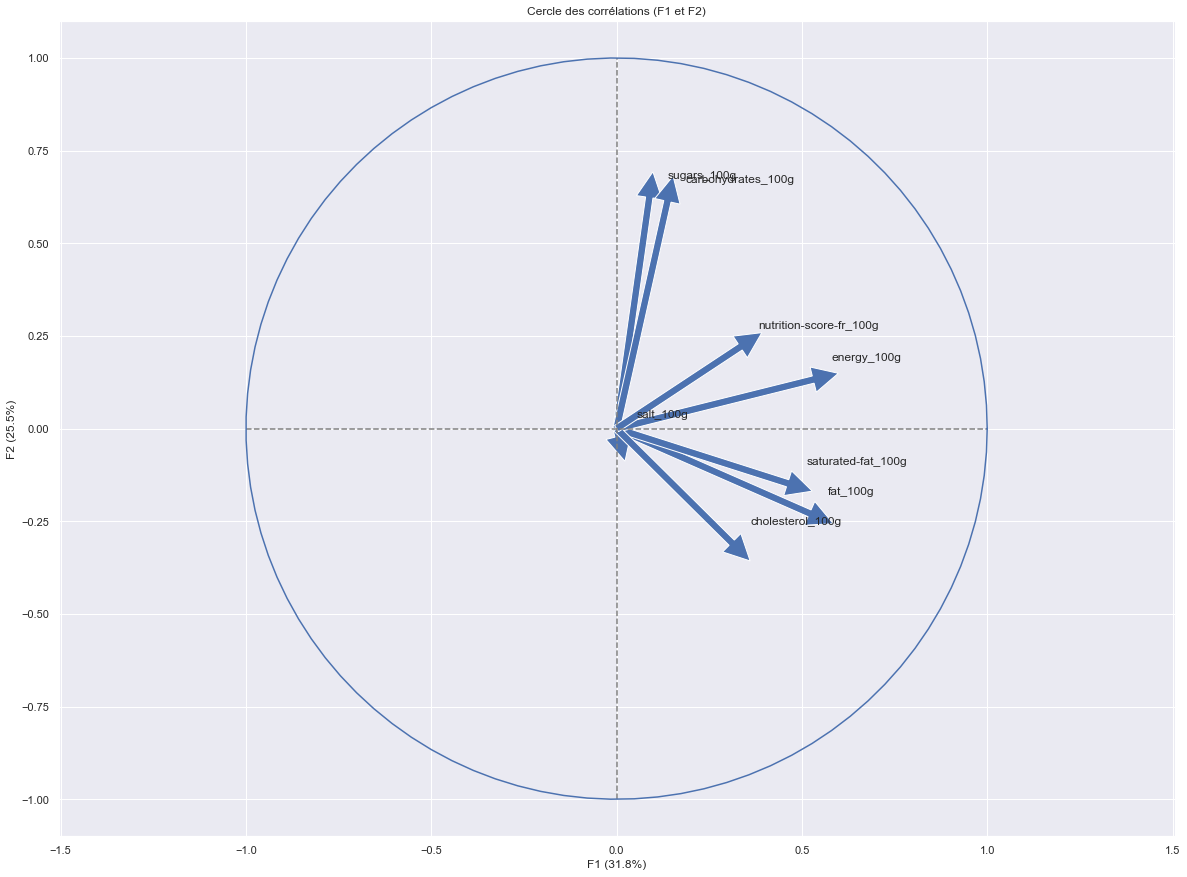

In [54]:
x, y = 0,1

fig, ax = plt.subplots(figsize=(20, 15))
for i in range(0, pca.components_.shape[1]):
    ax.arrow(0,
             0,  # Start the arrow at the origin
             pca.components_[0, i],  #0 for PC1
             pca.components_[1, i],  #1 for PC2
             head_width=0.07,
             head_length=0.07, 
             width=0.02,              )

    plt.text(pca.components_[0, i] + 0.05,
             pca.components_[1, i] + 0.05,
             features[i])
    
# affichage des lignes horizontales et verticales
plt.plot([-1, 1], [0, 0], color='grey', ls='--')
plt.plot([0, 0], [-1, 1], color='grey', ls='--')


# nom des axes, avec le pourcentage d'inertie expliqué
plt.xlabel('F{} ({}%)'.format(x+1, round(100*pca.explained_variance_ratio_[x],1)))
plt.ylabel('F{} ({}%)'.format(y+1, round(100*pca.explained_variance_ratio_[y],1)))

plt.title("Cercle des corrélations (F{} et F{})".format(x+1, y+1))


an = np.linspace(0, 2 * np.pi, 100)
plt.plot(np.cos(an), np.sin(an))  # Add a unit circle for scale
plt.axis('equal')
plt.show(block=False)

La corrélation de chaque point sur un axe exprime la qualité de représentation du point sur l'axe. Elle prend des valeurs entre 0 (pas corrélé du tout) et 1 (fortement corrélé). Si cette valeur est proche de 1, alors le point est bien représenté sur l'axe.

On obtient un graphique difficile exploitable et interpretable due au faible nombre de variable en entrée. La dimension 1 F1 va expliquer 31,8% du jeu de donnnées initial et la dimension 2 F2 va expliquer 25,5% de ce même jeu de données. Plus de 50% des données Vont expliquer la variance par les 2 premières composantes sur lesvariables.

L'axe F1 sera principalement entrainés par les variables Energy et Cholesterol.
L'axe F2 sera lui entrainé par le sucre et les glucides.

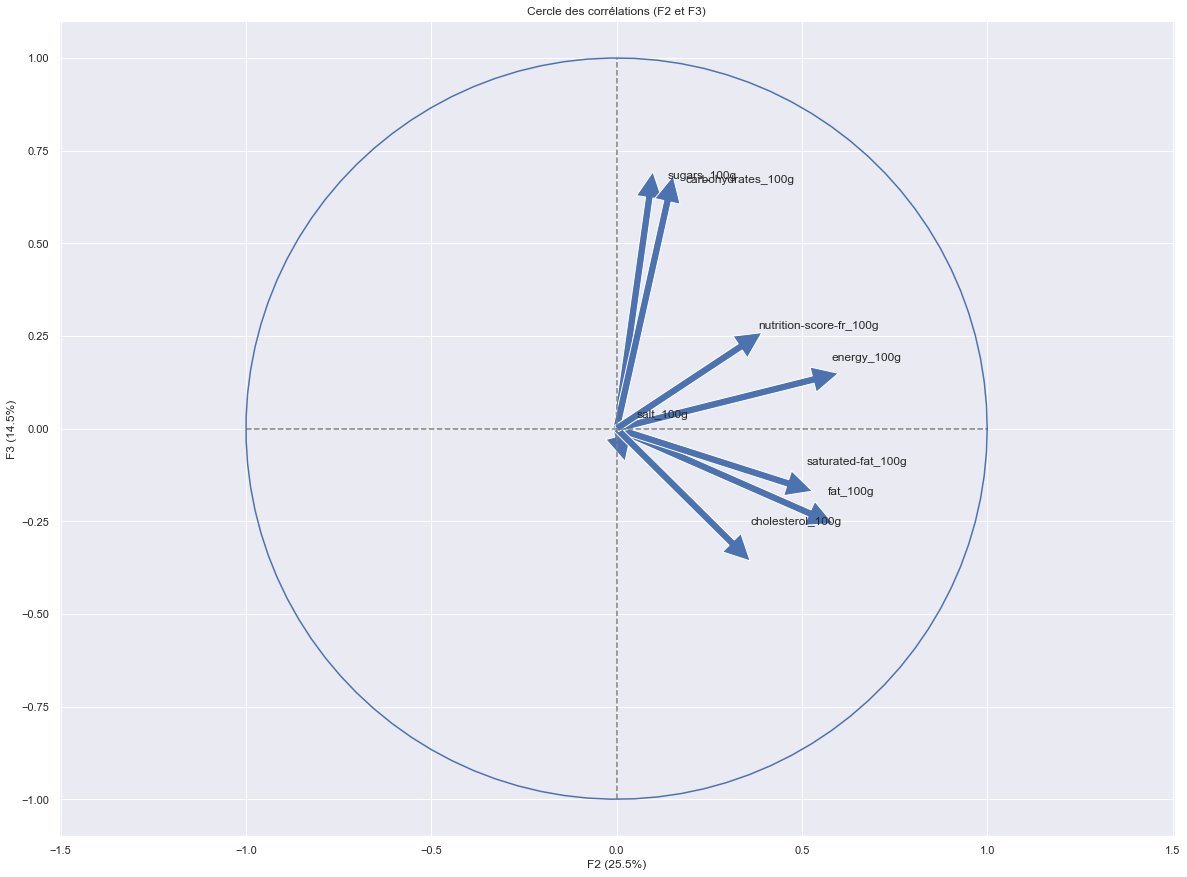

In [55]:
x, y = 1,2

fig, ax = plt.subplots(figsize=(20, 15))
for i in range(0, pca.components_.shape[1]):
    ax.arrow(0,
             0,  # Start the arrow at the origin
             pca.components_[0, i],  #0 for PC1
             pca.components_[1, i],  #1 for PC2
             head_width=0.07,
             head_length=0.07, 
             width=0.02,              )

    plt.text(pca.components_[0, i] + 0.05,
             pca.components_[1, i] + 0.05,
             features[i])
    
# affichage des lignes horizontales et verticales
plt.plot([-1, 1], [0, 0], color='grey', ls='--')
plt.plot([0, 0], [-1, 1], color='grey', ls='--')


# nom des axes, avec le pourcentage d'inertie expliqué
plt.xlabel('F{} ({}%)'.format(x+1, round(100*pca.explained_variance_ratio_[x],1)))
plt.ylabel('F{} ({}%)'.format(y+1, round(100*pca.explained_variance_ratio_[y],1)))

plt.title("Cercle des corrélations (F{} et F{})".format(x+1, y+1))


an = np.linspace(0, 2 * np.pi, 100)
plt.plot(np.cos(an), np.sin(an))  # Add a unit circle for scale
plt.axis('equal')
plt.show(block=False)

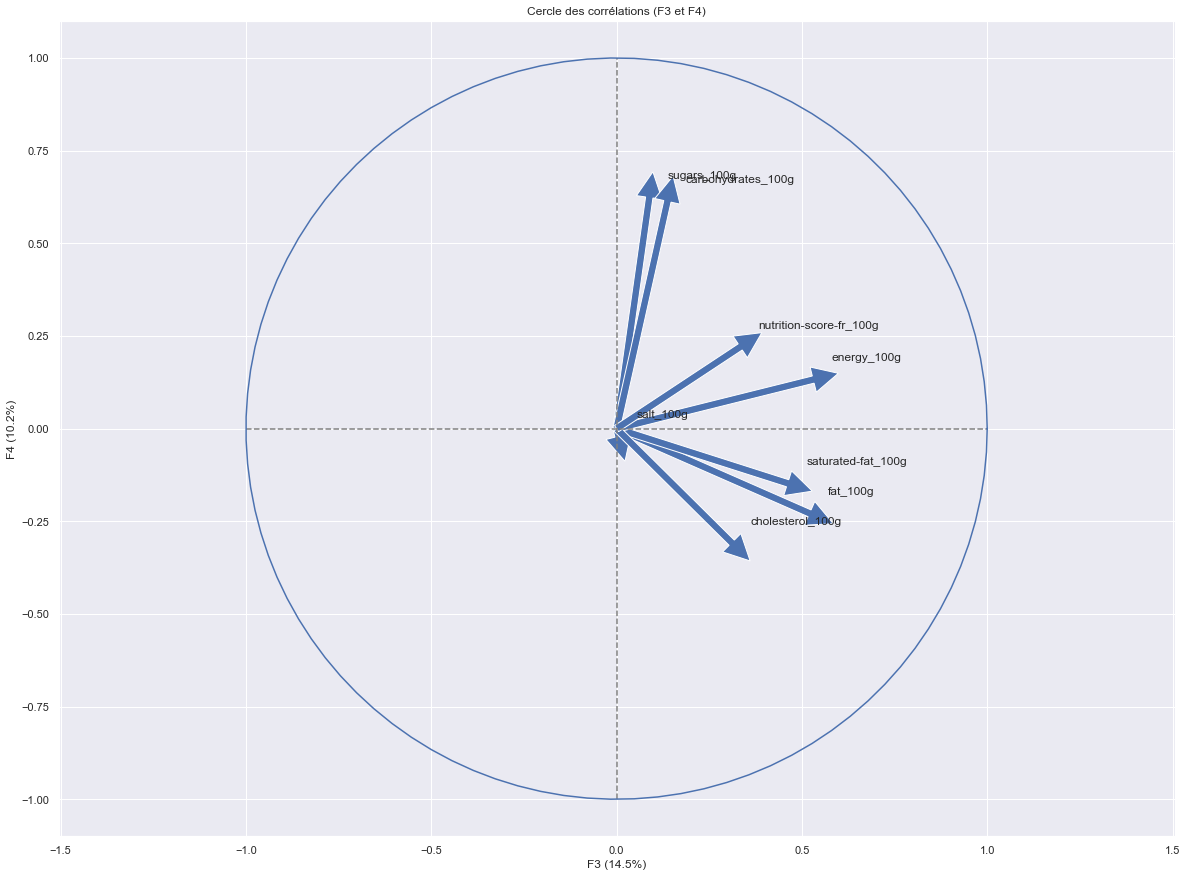

In [56]:
x, y = 2,3

fig, ax = plt.subplots(figsize=(20, 15))
for i in range(0, pca.components_.shape[1]):
    ax.arrow(0,
             0,  # Start the arrow at the origin
             pca.components_[0, i],  #0 for PC1
             pca.components_[1, i],  #1 for PC2
             head_width=0.07,
             head_length=0.07, 
             width=0.02,              )

    plt.text(pca.components_[0, i] + 0.05,
             pca.components_[1, i] + 0.05,
             features[i])
    
# affichage des lignes horizontales et verticales
plt.plot([-1, 1], [0, 0], color='grey', ls='--')
plt.plot([0, 0], [-1, 1], color='grey', ls='--')


# nom des axes, avec le pourcentage d'inertie expliqué
plt.xlabel('F{} ({}%)'.format(x+1, round(100*pca.explained_variance_ratio_[x],1)))
plt.ylabel('F{} ({}%)'.format(y+1, round(100*pca.explained_variance_ratio_[y],1)))

plt.title("Cercle des corrélations (F{} et F{})".format(x+1, y+1))


an = np.linspace(0, 2 * np.pi, 100)
plt.plot(np.cos(an), np.sin(an))  # Add a unit circle for scale
plt.axis('equal')
plt.show(block=False)

## ANOVA

In [57]:
import statsmodels.api
from scipy import stats

In [58]:
data_slf_anov = data_slf.copy()

ANOVA teste l'homogénéité de la moyenne de la variable quantitative étudiée sur les différentes valeurs de la variable qualitative. L'analyse de la variance, si elle aboutit à un résultat éloigné de zéro, permet de rejeter l'hypothèse nulle : la variable qualitative influe effectivement sur la variable quantitative.

 On renomme les variables colonnes car dans la fonction on ne peut utiliser des caractères types "-" dans le nom des colonnes.

In [59]:
##Renommage
data_slf_anov.rename({"nutrition-score-fr_100g": "nutrition_score_fr_100g"}, axis=1, inplace=True)
data_slf_anov.rename({"saturated-fat_100g": "saturated_fat_100g"}, axis=1, inplace=True)

In [60]:
data_slf_anov

,salt_100g,sugars_100g,fat_100g,saturated_fat_100g,energy_100g,cholesterol_100g,carbohydrates_100g,nutrition_score_fr_100g
0,0.49900,0.714,6.79,2.86,478.0,0.010700,7.860000,2.0
1,0.02540,10.400,0.00,0.00,177.0,0.000619,10.400000,13.0
2,0.10000,10.400,0.00,0.00,177.0,0.000645,10.400000,13.0
3,0.03810,10.420,0.00,0.00,192.0,0.000000,11.670000,2.0
4,0.01016,13.330,0.00,0.00,226.0,0.000000,13.330000,2.0
...,...,...,...,...,...,...,...,...
56627,1.05000,0.000,0.10,0.10,414.0,0.046662,0.100000,0.0
56628,0.54102,16.700,6.90,0.50,660.0,0.055353,23.100000,6.0
56629,10.00000,1.000,0.00,1.00,4.0,0.000000,4.131414,0.0
56630,0.02540,0.500,0.20,0.20,21.0,0.000000,0.500000,2.0


In [61]:
for col in data_slf_anov.columns :
    k2, p = stats.normaltest(data_slf_anov[col])
    alpha = 1e-58
    print("===============")
    print("  ")
    print("p = {:g}".format(p))
    if p < alpha:  # null hypothesis: x comes from a normal distribution
        print(f"L'hypothèse nulle est rejeté.{col} n'est pas distribué normalement")
    else:
        print(f"L'hypothèse nulle n'est pas rejetée.{col} est distribuée normalement")
 

  
p = 0
L'hypothèse nulle est rejeté.salt_100g n'est pas distribué normalement
  
p = 0
L'hypothèse nulle est rejeté.sugars_100g n'est pas distribué normalement
  
p = 0
L'hypothèse nulle est rejeté.fat_100g n'est pas distribué normalement
  
p = 0
L'hypothèse nulle est rejeté.saturated_fat_100g n'est pas distribué normalement
  
p = 0
L'hypothèse nulle est rejeté.energy_100g n'est pas distribué normalement
  
p = 0
L'hypothèse nulle est rejeté.cholesterol_100g n'est pas distribué normalement
  
p = 0
L'hypothèse nulle est rejeté.carbohydrates_100g n'est pas distribué normalement
  
p = 0
L'hypothèse nulle est rejeté.nutrition_score_fr_100g n'est pas distribué normalement


On part de l'hypothèse que les données sont homogènes.Malheuresemet, aucunes des variables ne suivent une loi normale. Il est donc impossible de mettre en place un test ANOVA.

Mais dans l'optique d'apprentissage nous allons faire l'hypothèse que ces données soont bien distribuées suivant une loi normal et appliquer le test ANOVA.

## Anova

L’analyse de la variance (ANOVA) est unr méthode analytique puissante sert à mettre en avant des différences ou des dépendances entre plusieurs groupes statistiques.

La méthode ANOVA est utilisée pour étudier le rapport de dépendance d'une variable quantitative à une ou deux variables qualitatives


In [62]:
mdl = statsmodels.formula.api.ols("nutrition_score_fr_100g ~ saturated_fat_100g",data =data_slf_anov  )
res = mdl.fit()

table = statsmodels.api.stats.anova_lm(res)

table

,df,sum_sq,mean_sq,F,PR(>F)
saturated_fat_100g,1.0,7.325568e+04,73255.675285,3742.295997,0.0
Residual,56630.0,1.108536e+06,19.575062,NaN,NaN


In [63]:
mdl = statsmodels.formula.api.ols("nutrition_score_fr_100g ~ sugars_100g",data =data_slf_anov)
res = mdl.fit()

table1 = statsmodels.api.stats.anova_lm(res)
table = table.append(table1)
table

,df,sum_sq,mean_sq,F,PR(>F)
saturated_fat_100g,1.0,7.325568e+04,73255.675285,3742.295997,0.0
Residual,56630.0,1.108536e+06,19.575062,NaN,NaN
sugars_100g,1.0,1.145415e+05,114541.532203,6077.758382,0.0
Residual,56630.0,1.067250e+06,18.846016,NaN,NaN


In [64]:
data_slf_anov

,salt_100g,sugars_100g,fat_100g,saturated_fat_100g,energy_100g,cholesterol_100g,carbohydrates_100g,nutrition_score_fr_100g
0,0.49900,0.714,6.79,2.86,478.0,0.010700,7.860000,2.0
1,0.02540,10.400,0.00,0.00,177.0,0.000619,10.400000,13.0
2,0.10000,10.400,0.00,0.00,177.0,0.000645,10.400000,13.0
3,0.03810,10.420,0.00,0.00,192.0,0.000000,11.670000,2.0
4,0.01016,13.330,0.00,0.00,226.0,0.000000,13.330000,2.0
...,...,...,...,...,...,...,...,...
56627,1.05000,0.000,0.10,0.10,414.0,0.046662,0.100000,0.0
56628,0.54102,16.700,6.90,0.50,660.0,0.055353,23.100000,6.0
56629,10.00000,1.000,0.00,1.00,4.0,0.000000,4.131414,0.0
56630,0.02540,0.500,0.20,0.20,21.0,0.000000,0.500000,2.0


In [65]:
mdl = statsmodels.formula.api.ols("nutrition_score_fr_100g ~ salt_100g",data =data_slf_anov  )
res = mdl.fit()

table1 = statsmodels.api.stats.anova_lm(res)
table = table.append(table1)

mdl = statsmodels.formula.api.ols("nutrition_score_fr_100g ~ energy_100g",data =data_slf_anov  )
res = mdl.fit()

table1 = statsmodels.api.stats.anova_lm(res)
table = table.append(table1)

mdl = statsmodels.formula.api.ols("nutrition_score_fr_100g ~ carbohydrates_100g	",data =data_slf_anov  )
res = mdl.fit()

table1 = statsmodels.api.stats.anova_lm(res)
table = table.append(table1)

mdl = statsmodels.formula.api.ols("nutrition_score_fr_100g ~ fat_100g",data =data_slf_anov  )
res = mdl.fit()

table1 = statsmodels.api.stats.anova_lm(res)
table = table.append(table1)


table

,df,sum_sq,mean_sq,F,PR(>F)
saturated_fat_100g,1.0,7.325568e+04,73255.675285,3742.295997,0.0
Residual,56630.0,1.108536e+06,19.575062,NaN,NaN
sugars_100g,1.0,1.145415e+05,114541.532203,6077.758382,0.0
Residual,56630.0,1.067250e+06,18.846016,NaN,NaN
salt_100g,1.0,6.421366e+04,64213.662998,3253.840463,0.0
Residual,56630.0,1.117578e+06,19.734730,NaN,NaN
energy_100g,1.0,1.303878e+05,130387.765697,7022.858557,0.0
Residual,56630.0,1.051404e+06,18.566196,NaN,NaN
carbohydrates_100g,1.0,4.748900e+04,47489.000250,2370.886309,0.0
Residual,56630.0,1.134302e+06,20.030062,NaN,NaN


In [66]:
data_anova = data

In [67]:
data_anova.rename({"nutrition-score-fr_100g": "nutrition_score_fr_100g"}, axis=1, inplace=True)

In [68]:
mdl = statsmodels.formula.api.ols("nutrition_score_fr_100g ~ nutrition_grade_fr ",data =data_anova  )
res = mdl.fit()

table1  = statsmodels.api.stats.anova_lm(res)
table = table.append(table1)
table

,df,sum_sq,mean_sq,F,PR(>F)
saturated_fat_100g,1.0,7.325568e+04,73255.675285,3742.295997,0.0
Residual,56630.0,1.108536e+06,19.575062,NaN,NaN
sugars_100g,1.0,1.145415e+05,114541.532203,6077.758382,0.0
Residual,56630.0,1.067250e+06,18.846016,NaN,NaN
salt_100g,1.0,6.421366e+04,64213.662998,3253.840463,0.0
Residual,56630.0,1.117578e+06,19.734730,NaN,NaN
energy_100g,1.0,1.303878e+05,130387.765697,7022.858557,0.0
Residual,56630.0,1.051404e+06,18.566196,NaN,NaN
carbohydrates_100g,1.0,4.748900e+04,47489.000250,2370.886309,0.0
Residual,56630.0,1.134302e+06,20.030062,NaN,NaN


In [69]:
mdl = statsmodels.formula.api.ols("nutrition_score_fr_100g ~ countries_tags",data =data_anova  )
res = mdl.fit()


table1  = statsmodels.api.stats.anova_lm(res)
table = table.append(table1)
table

,df,sum_sq,mean_sq,F,PR(>F)
saturated_fat_100g,1.0,7.325568e+04,73255.675285,3742.295997,0.000000e+00
Residual,56630.0,1.108536e+06,19.575062,NaN,NaN
sugars_100g,1.0,1.145415e+05,114541.532203,6077.758382,0.000000e+00
Residual,56630.0,1.067250e+06,18.846016,NaN,NaN
salt_100g,1.0,6.421366e+04,64213.662998,3253.840463,0.000000e+00
Residual,56630.0,1.117578e+06,19.734730,NaN,NaN
energy_100g,1.0,1.303878e+05,130387.765697,7022.858557,0.000000e+00
Residual,56630.0,1.051404e+06,18.566196,NaN,NaN
carbohydrates_100g,1.0,4.748900e+04,47489.000250,2370.886309,0.000000e+00
Residual,56630.0,1.134302e+06,20.030062,NaN,NaN


Avec un p valeur inférieur à 0.05 nous pouvons rejeter l'hypothèse d'indépendance des variables. Les variables ont bien uné dépendance avec le nutriscore. 

Bien que les hypothèses d'homogénéites et de normalié ne sont pas valident, nous sommes parti du cas qu'elles le sont. Le nutriscore est bien influencé par les features choisies :
- salt_100g
- sugars_100g
- fat_100g
- saturated-fat_100g
- energy_100g
- cholesterol_100g
- carbohydrates_100g

Il est donc possible de mettre en place notre idée d'application avec un jeu d edonnées réduit avec la liste des données ci-dessus.